<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2022</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 1</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

In this part, we will use the Australian Government Bond market data found in <A HREF="https://www2.asx.com.au/content/dam/asx/investors/investment-options/bonds/2022/xlxs/asx-bonds-monthly-report-jul-2022-abs.xlsx">this file on the ASX website</A>. In order to interpret this data, you may also wish to refer to the <A HREF="https://www2.asx.com.au/content/dam/asx/participants/cash-market/bonds/ASX-42301-AGB-Fact-Sheet.pdf">AGB Fact Sheet</A>. In particular, you will need to consider accrued interest when interpreting the bond prices in the data file.

#### Importing the libararies

In [31]:
import pandas as pd
from IPython.display import display, HTML, Math, Markdown
from datetime import timedelta, datetime
import math
import numpy as np
import scipy.optimize as opt
from scipy.optimize import minimize
from pylab import plt, mpl
%matplotlib inline
from dateutil.relativedelta import relativedelta
mpl.rcParams['font.family'] = 'serif'
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
%matplotlib inline

#### Importing the data

In [32]:
## Setting some constants
FV = 100
value_date = datetime(2022, 7, 31)
date_of_payment = datetime(2022,7,21)

## Importing the data
df = pd.read_excel(r'asx-bonds-monthly-report-jul-2022-abs.xlsx')

## Pulling data from the spreadsheet
Listed_Date = []
Maturity = []
Coupon = []
Last =[]
lc = []
for i in range(14,42):
    Listed_Date.append(df.iat[i,7])
    Maturity.append(df.iat[i,8])
    Coupon.append(df.iat[i,9])
    Last.append(df.iat[i,22])
    lc.append(df.iat[i,12])

## Creating a bonds dataframe with all the data
bonds = pd.DataFrame(None)
bonds['Listed_Date'] = pd.to_datetime(Listed_Date)
bonds['Maturity'] = pd.to_datetime(Maturity)
bonds['T-t (Days)'] = (bonds['Maturity'] - bonds['Listed_Date']) 
bonds['T-t (Yrs)'] = (bonds['T-t (Days)'].dt.days)/365
bonds['Coupon'] = Coupon
bonds['Last'] = Last
bonds['Mat - VD'] = ((bonds['Maturity'] - value_date).dt.days)/365
bonds['First Payment'] = lc

## Creating a loop of monthly dataes
final_date = bonds.iat[len(bonds)-1,1]
x = date_of_payment
y = [x]
while x < final_date:
    x += relativedelta(months = 1)
    y.append(x)

## Creating an empty (bar t = 0) dataframe of all the zcb_df prices
zcb_df = pd.DataFrame(None)
zcb_df['Date'] = y
zcb_df['zcbPrice'] = 0
zcb_df.iat[0,1] = 1

## Taking the important bond data from the bonds dataframe - for task 1 and 2
bond_data =  pd.DataFrame(None)
bond_data['Maturity'] = bonds['Maturity']
bond_data['Coupon'] = bonds['Coupon']
bond_data['Last'] = bonds['Last']
display(zcb_df.head(), bond_data.head())

,Date,zcbPrice
0,2022-07-21,1
1,2022-08-21,0
2,2022-09-21,0
3,2022-10-21,0
4,2022-11-21,0


,Maturity,Coupon,Last
0,2022-11-21,0.0225,100.409
1,2023-04-21,0.0550,103.950
2,2024-04-21,0.0275,101.660
3,2024-11-21,0.0025,94.891
4,2025-04-21,0.0325,102.440


<H2>Task 1:</H2>
Based on the prices for fixed rate Australian Government Bonds in the column marked "last", determine the term structure of zero coupon bond prices that these prices imply, using loglinear interpolation where necessary. <I>(6 marks)</I>

#### Now we have the above data in a desireable format, we need to create some functions, namely:
   - One that uses log linear interpolation defined by:
$$
B(t,T_i) = exp\left(\ln B(t,T_1) + \frac{T_i-T_1}{T_2-T_1}
\ln\left(\frac{B(t,T_2)}{B(t,T_1)}\right) \right)
$$
   - Another that finds the coupon payment dates for each bond in 'Bonds'.
   - One that calculates monthly zcb prices at $T_i$ between $T_1$ and $T_2$.
   - A final function that calculates this, but when we have unknown prices at $T_1$ and $T_2$.

In [50]:
def zcbLogLinear(Ti:datetime, T1:datetime, T2:datetime, ZCB1:float, ZCB2:float):
    ZCBi = np.exp((np.log(ZCB1)) + ((((Ti - T1).days) / (T2 - T1).days)*np.log((ZCB2 / ZCB1)))) 
    return ZCBi

def k_payment_dates(end_date:datetime) :
    y = end_date
    x = [y]
    while y > value_date:
        y -= relativedelta(months = 6)
        x.append(y)
    x.reverse()
    x.pop(0)
    return x

def zcb_price_1_2(zcb_df:pd.DataFrame):
    # Find the non-zero rows
    ad = zcb_df[(zcb_df['zcbPrice']!=0)]
    # Finds the last value in the zcb_dfframe
    T1 = ad.iloc[-2]['Date']
    T2 = ad.iloc[-1]['Date']
    ZCB1 = ad.iloc[-2]['zcbPrice']
    ZCB2 = ad.iloc[-1]['zcbPrice']
    # ZCBi middle
    empties = zcb_df[(zcb_df['zcbPrice'] == 0) & (zcb_df['Date'] < T2)]
    for i in range(len(empties)):
        Ti=(empties.iat[i,0]).to_pydatetime()
        zcb_df.loc[zcb_df['Date'] == Ti, 'zcbPrice'] = zcbLogLinear(Ti, T1, T2, ZCB1, ZCB2)
    return zcb_df

def bondPrice(zcb2:float, price:float, k:float, k_payment_dates:list,zcb_df:float):
    # for each coupon date in the list, but not the last one
    p = [price]
    for j in range(0,len(k_payment_dates)-1):
        dtee = k_payment_dates[j] 
        test = float(zcb_df.loc[zcb_df['Date'] == dtee, 'zcbPrice'])       
        if test != 0:
            cp  = -1*((k/2)*FV)
            d = cp*test
            p.append(d)
        else:
            T_1 = zcb_df.loc[(zcb_df['Date'] < dtee) & zcb_df['zcbPrice'] != 0, 'Date'][0]
            ZCB1 = float(zcb_df.loc[zcb_df['Date'] == T_1, 'zcbPrice'])
            cp = -1*((k/2)*FV)
            d = cp*zcbLogLinear(dtee, T_1, k_payment_dates[-1], ZCB1, zcb2)
            p.append(d)
    # Final cashflow , make all values negative so we are taking values off
    # the coupon bond price
    p.append(-1*(FV+(k/2*FV))*zcb2)
    final = float(sum(p))
    return final

In [55]:
for i in range (len(bond_data)):
    sol = opt.root_scalar(bondPrice, bracket = [0.0001, 1], args= (bond_data.iat[i,2], bond_data.iat[i,1],  k_payment_dates(bond_data.iat[i,0]), zcb_df))
    zcb_df.loc[zcb_df['Date'] == bond_data.iat[i,0], 'zcbPrice'] = sol.root
    zcb_df = zcb_price_1_2(zcb_df)
display(zcb_df)

,Date,zcbPrice,Mat (from t0 in yrs),Foward Rate,NS Forward,Sq Error fwds
0,2022-07-21,1.000000,-0.027397,None,0.024675,NaN
1,2022-08-21,0.998211,0.057534,0.021104,0.024647,0.000013
2,2022-09-21,0.996425,0.142466,0.021104,0.024633,0.000012
3,2022-10-21,0.994699,0.224658,0.021104,0.024631,0.000012
4,2022-11-21,0.992920,0.309589,0.021104,0.024642,0.000013
...,...,...,...,...,...,...
343,2051-02-21,0.380832,28.580822,0.025203,0.037546,0.000152
344,2051-03-21,0.380097,28.657534,0.025201,0.037546,0.000152
345,2051-04-21,0.379285,28.742466,0.025203,0.037546,0.000152
346,2051-05-21,0.378501,28.824658,0.025203,0.037546,0.000152


#### Plotting the results

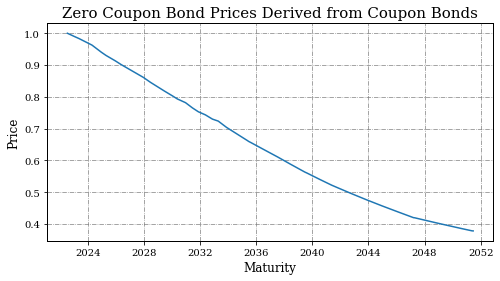

In [56]:
fig, (ax1) = plt.subplots(1,figsize=(8,4));
ax1.plot(zcb_df['Date'],zcb_df['zcbPrice']);
ax1.set(xlabel ='Maturity');
ax1.set(ylabel = 'Price');
ax1.set(xlabel ='Maturity');
ax1.set_title('Zero Coupon Bond Prices Derived from Coupon Bonds',size=15);
ax1.xaxis.get_label().set_fontsize(12);
ax1.yaxis.get_label().set_fontsize(12);
ax1.set(facecolor = 'white');
ax1.grid(color='Gray', linestyle='-.', linewidth=0.7);
ax1.patch.set_edgecolor('black'); 
ax1.patch.set_linewidth('1'); 

<H2>Task 2:</H2>
Consider the Nelson/Siegel term structure parameterisation introduced in the lectures. Find the Nelson/Siegel parameters such that the sum of squared differences between the bond prices implied by the Nelson/Siegel term structure and the actual market prices of the fixed rate Australian Government Bonds in the column marked "last" is minimised. <I>(8 marks)</I>

So here, I integrated the Nelson Siegel formula for forward rates to generate a function that gives us the Nelson Sigel discount prices, then because we have the bond price, face value and the coupon rate, we can calculate the cashflows associated with each bond at each time (for each bond). Leading us to the following formula.

$$ P(t_m) = \sum_{m}^{j = 1} CF_{j} \cdot e^{t_j(-f_0 - (f_2+f_3)\frac{\gamma}{t_j}(1-e^{-t_j/\gamma})+f_3e^{-t_j/\gamma})} $$

Once I had this formula, I wrote a single function named price, which takes some Neslon Siegel parameters, and uses these to effectively price every bond in the set data. I did this one just using a list of lists in each case, and in one function, it seemed easier to keep track of!

In [37]:
def Price(args:np.array):
    ## Arguments import
    f0 = args[0]
    f1 = args[1]
    f2 = args[2]
    y = args[3]
    
    ## Creating a term structure for each bond
    yd_arr = zcb_df['Date']
    bm = pd.DataFrame(None)
    bm['Mats'] = (bond_data['Maturity'])
    payment_dates = []
    for i in range(0,len(bonds)):
        final_date = bm.iat[i,0]
        first_coupon = bonds.iat[i,7]
        p = first_coupon
        q = [p]
        while p < final_date:
            p += relativedelta(months = 6)
            q.append(p)
        payment_dates.append(q)

    r = []
    for d in range(0,len(payment_dates)):
        pdt = (payment_dates[d])
        x = []
        for f in range(0,len(pdt)):
            for i, j in enumerate(yd_arr):
                if j == pdt[f]:
                    x.append(i)
        r.append(x)
    
    all_dates_new = []  
    for b in range(0,len(r)):    
        rx = r[b]
        j = []
        for i in rx:
            j.append((yd_arr[i].to_pydatetime() - value_date).days/365)
        all_dates_new.append(j)   
    
    ## Creating a discount factore (via the above formula) for each of the 
    ## cashflows at t
    gog = []
    for c in range(0,len(all_dates_new)):   
        re = []
        ad = all_dates_new[c] 
        for i in range(0,len(ad)):
            dv = ad[i]
            dfs = np.exp((-f0 - (f1 + f2)*(y / dv)*(1 - np.exp(-dv / y)) + f2 * np.exp(-dv / y)) * dv)
            re.append(dfs)
        gog.append(re)
    
    ## Cashflows at each time throughout the life of each bond
    cps = []
    for l in range(0,len(bonds)):
        pds = gog[l]
        x = []
        for i in range(0,len(pds)-1):
            coupon = FV*bonds.iat[l,4]/2
            x.append(round(coupon,4))
        x.append(FV+(FV*bonds.iat[l,4]/2))
        cps.append(x)
        
    ## Now butting gog, and cps together, we land at a bond price, a sum of discounted cashflows
    z = []
    for j in range(0,len(cps)):
        fg = cps[j]
        tt = gog[j]
        v = []
        for i in range(0,len(fg)):
            v.append(fg[i]*tt[i])
        s_dc_cf = sum(v)
        z.append(s_dc_cf)
        
    ## Return the price    
    return np.array(z)

#### Now, finding the sum of squared errors, and minimising

In [38]:
## Creating an array of BondPrices
BondPrices = np.array(bond_data['Last'])

## SSE
def sse(args):
    return np.sum((Price(args) - BondPrices)**2)

## Minimising sum
result = np.array(minimize(sse, x0 = (0.01,0.01,0.01,1)).x)

In [39]:
ar = np.array([result[0], result[1], result[2], result[3]])

display(Markdown('NS Paramters Answers:'))
display(Markdown(str('f_0: ') + str(round(ar[0],8))))
display(Markdown(str('f_1: ') + str(round(ar[1],8))))
display(Markdown(str('f_2: ') + str(round(ar[2],8))))
display(Markdown(str('y: ') + str(round(ar[3],8))))

NS Paramters Answers:

f_0: 0.03755065

f_1: -0.01288608

f_2: -0.01386831

y: 2.73250588

Below I get the results from these and plot their results against the actual bond prices:

$$ NS Parameters: f_0 = 0.03755065, f_1 = -0.01288608, f_2 = -0.01386831, \gamma = 2.73250588 $$

#### Plotting these results against eachother

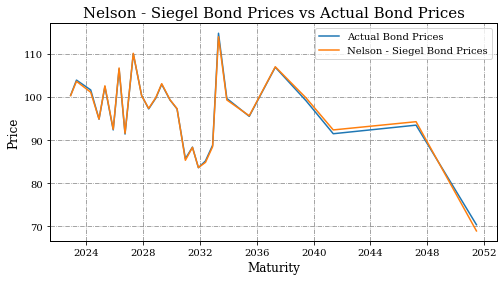

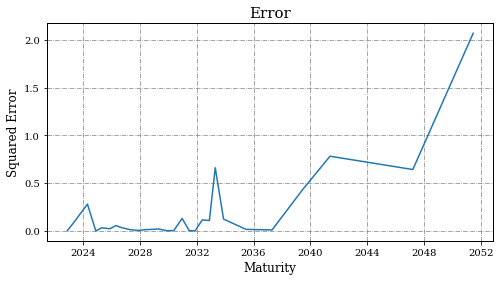

In [40]:
## Results
predicted = Price(ar)

## Creating a data frame of results
t2_ans = pd.DataFrame(None)
t2_ans['Maturity'] = bond_data['Maturity']
t2_ans['Actual Bond Price'] = BondPrices
t2_ans['NS Prices'] = predicted
t2_ans['Sq Error'] = (t2_ans['Actual Bond Price'] - t2_ans['NS Prices'])**2

fig, (ax1) = plt.subplots(1,figsize=(8,4));
ax1.plot(t2_ans['Maturity'],t2_ans['Actual Bond Price']);
ax1.plot(t2_ans['Maturity'],t2_ans['NS Prices']);
ax1.set(xlabel ='Maturity');
ax1.set(ylabel = 'Price');
ax1.set(xlabel ='Maturity');
ax1.set_title('Nelson - Siegel Bond Prices vs Actual Bond Prices',size=15);
ax1.xaxis.get_label().set_fontsize(12);
ax1.yaxis.get_label().set_fontsize(12);
ax1.set(facecolor = 'white');
ax1.grid(color='Gray', linestyle='-.', linewidth=0.7);
ax1.patch.set_edgecolor('black'); 
ax1.patch.set_linewidth('1'); 
ax1.legend(['Actual Bond Prices', 'Nelson - Siegel Bond Prices']);

fig, (ax1) = plt.subplots(1,figsize=(8,4));
ax1.plot(t2_ans['Maturity'],t2_ans['Sq Error']);
ax1.set(xlabel ='Maturity');
ax1.set(ylabel = 'Squared Error');
ax1.set(xlabel ='Maturity');
ax1.set_title('Error',size=15);
ax1.xaxis.get_label().set_fontsize(12);
ax1.yaxis.get_label().set_fontsize(12);
ax1.set(facecolor = 'white');
ax1.grid(color='Gray', linestyle='-.', linewidth=0.7);
ax1.patch.set_edgecolor('black'); 
ax1.patch.set_linewidth('1'); 

<H2>Task 3:</H2>
Plot the term structure of instantaneous forward rates resulting from Task 1 and Task 2 in a single graph. <I>(1 mark)</I>

For the instantansous forward rates, I used the original $f(t)$ function from the lectures and create a function: NelsonSiegelFWD that calculates these forward rates at each T (T being every month, analogous to the task 1 result)

$$ f(t) = f_0 + f_1\cdot e^{-t/\gamma}  + f_2\cdot \frac{t}{\gamma}\cdot e^{-t/\gamma}$$

I use the below function to calculate them from the zcb results from task 1.

$$
L(T_0,T_i)=\frac1{T_{i+1}-T_i}\cdot\left(\frac{B(T_0,T_i)}{B(T_0,T_{i+1})}-1\right)
$$

In [41]:
zcb_df['Mat (from t0 in yrs)'] = ((zcb_df['Date'] - value_date).dt.days)/365
mat = np.array(zcb_df['Mat (from t0 in yrs)'])
zcb_df['Foward Rate'] = None
for i in range(1,len(zcb_df)):
    timediff = 1 / (zcb_df.iat[i,2] - zcb_df.iat[i-1,2])
    quotient= (zcb_df.iat[i-1,1] / zcb_df.iat[i,1]) - 1
    zcb_df.iat[i,3] = (timediff * quotient)

In [42]:
def NelsonSiegelFWD(arg:np.array):
    f0 = arg[0]
    f1 = arg[1]
    f2 = arg[2]
    y = arg[3]
    x = []
    for T in mat:
        fwd = (f0 + f1*np.exp(-T/y) + f2*(T/y)*np.exp(-T/y))
        x.append(fwd)
    FWD = np.array(x)
    return FWD
ans2 = (NelsonSiegelFWD(ar))
zcb_df['NS Forward'] = ans2
zcb_df_plt = zcb_df
zcb_df_plt['Sq Error fwds'] = (zcb_df['NS Forward'] - zcb_df['Foward Rate'])**2
zcb_df_plt = zcb_df.iloc[1: , :]
zcb_df_plt.head()

,Date,zcbPrice,Mat (from t0 in yrs),Foward Rate,NS Forward,Sq Error fwds
1,2022-08-21,0.998211,0.057534,0.021104,0.024647,0.000013
2,2022-09-21,0.996425,0.142466,0.021104,0.024633,0.000012
3,2022-10-21,0.994699,0.224658,0.021104,0.024631,0.000012
4,2022-11-21,0.992920,0.309589,0.021104,0.024642,0.000013
5,2022-12-21,0.991352,0.391781,0.019233,0.024663,0.000029


#### Plotting the data

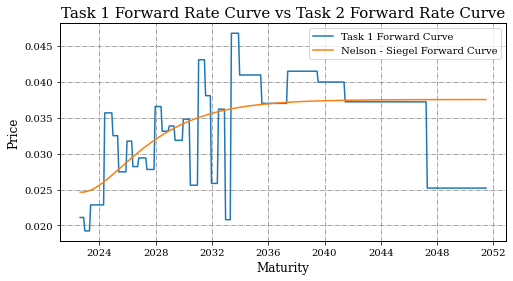

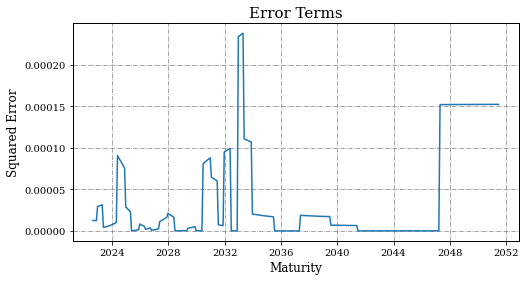

In [43]:
fig, (ax1) = plt.subplots(1,figsize=(8,4));
ax1.plot(zcb_df['Date'],zcb_df['Foward Rate']);
ax1.plot(zcb_df_plt['Date'],zcb_df_plt['NS Forward']);
ax1.set(xlabel ='Forward Rate');
ax1.set(ylabel = 'Price');
ax1.set(xlabel ='Maturity');
ax1.set_title('Task 1 Forward Rate Curve vs Task 2 Forward Rate Curve',size=15);
ax1.xaxis.get_label().set_fontsize(12);
ax1.yaxis.get_label().set_fontsize(12);
ax1.set(facecolor = 'white');
ax1.grid(color='Gray', linestyle='-.', linewidth=0.7);
ax1.patch.set_edgecolor('black'); 
ax1.patch.set_linewidth('1'); 
ax1.legend(['Task 1 Forward Curve', 'Nelson - Siegel Forward Curve']);

fig, (ax1) = plt.subplots(1,figsize=(8,4));
ax1.plot(zcb_df_plt['Date'],zcb_df_plt['Sq Error fwds']);
ax1.set(xlabel ='Maturity');
ax1.set(ylabel = 'Squared Error');
ax1.set(xlabel ='Maturity');
ax1.set_title('Error Terms',size=15);
ax1.xaxis.get_label().set_fontsize(12);
ax1.yaxis.get_label().set_fontsize(12);
ax1.set(facecolor = 'white');
ax1.grid(color='Gray', linestyle='-.', linewidth=0.7);
ax1.patch.set_edgecolor('black'); 
ax1.patch.set_linewidth('1'); 